Постановка задачи:
$$\underset{x \in S}{min} \; f(x) = \frac{1}{2} (x, Ax) + (b, x)$$
$$S = \{ x \in \mathbb{R}^n : (x,x) = 1 \}$$

In [2]:
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt
%matplotlib inline

Далее определим матрицу $A$, вектор-стоблец $b$, размерность пространства (автоматически из размерности $A$)

In [3]:
A = np.array([[1., 0., 2.], [0., 2., 1.], [2., 1., 5.]])
b = np.array([-1., -1., -1.])
print A
print b
n = A.shape[0]

[[ 1.  0.  2.]
 [ 0.  2.  1.]
 [ 2.  1.  5.]]
[-1. -1. -1.]


In [4]:
def F(x):
    return 0.5 * x.dot(np.dot(A, x)) + np.dot(b,x)

In [5]:
x0 = np.array([1., 1., 1.])
x0 = x0 / np.linalg.norm(x0)
G0 = A.dot(x0) + b - x0*(np.dot(A.dot(x0) + b, x0))
H0 = - G0

In [18]:
def armijoRule(f, gradf, tau):
    alpha = 0.9
    eps = 0.9
    ro = 0.5
    i = 0
    #print 'ARMIJO DEBUG:'
    #print 'tau = ', tau
    #print 'first arg = ', tau - alpha * gradf(tau)
    #print 'gradf(tau) = ', gradf(tau)
    #print 'f(tau) = ', f(tau)
    while (f(tau - alpha * gradf(tau)) - f(tau) > - eps * alpha * gradf(tau) * gradf(tau)) and (i < 100):
        #if i % 10 == 0:
            #print 'Armijo iteration number: ', i
        alpha = alpha * ro
        i += 1
    return alpha

In [20]:
def GetNewMN(x, H, Q, R, A, b, t0 = 0):
    #QR dec of vector is Q = unit vector and R is its norm
    Ahat = x.dot(H)
    #toBeQRed = (np.eye(len(x)) - np.dot(x.reshape(len(x), 1),x.reshape(1, len(x)))).dot(H)
    #Q = toBeQRed / np.linalg.norm(toBeQRed)
    #R = np.linalg.norm(toBeQRed)
    #print 'GetNewT DEBUG: '
    #print 'x shape = ', x.shape
    underExp = np.array([[Ahat, -R], [R, 0]])
    expm = lambda t: linalg.expm(t * underExp)
    M = lambda t: expm(t)[0][0]
    N = lambda t: expm(t)[1][0]
    gradMinT = lambda t: (x * M(t) + Q * N(t)).dot(np.dot(A, x * (underExp.dot(expm(t)))[0][0] + Q * (underExp.dot(expm(t)))[1][0])) + np.dot(b, x * (underExp.dot(expm(t)))[0][0] + Q * (underExp.dot(expm(t)))[1][0]) 
    MinT = lambda t: 0.5 * np.dot((x * M(t) + Q * N(t)), A.dot(x * M(t) + Q * N(t))) + b.dot(x * M(t) + Q * N(t))
    tk = t0
    #print 'gradMinT(1) = ', gradMinT(1)
    #print 'underExp.dot(expm(t))[0][0] = ', underExp.dot(expm(10.))[0][0]
    #print 'gradMinT shape  = ', gradMinT(tk).shape
    #print 'backtracking line search shape = ', len(backtracking_line_search(MinT, gradMinT, tk))
    #tkk = tk + backtracking_line_search(MinT, gradMinT, tk) * gradMinT(tk)
    tkk = tk - armijoRule(MinT, gradMinT, tk) * gradMinT(tk)
    j = 0
    #print 'GetNewMN before while: tk = ', tk
    #print 'GetNewMN before while: tkk = ', tkk
    while (np.abs(tk - tkk) > 1e-2):
        #print 'GetNewMN while iter num = ', j
        tk = tkk
        #print 'GetNewMN in while: tk = ', tk
        #print 'GetNewMN in while: MinT = ', MinT(tk)
        #print 'GetNewMN in while: MinT arg: '
        #print (x * expm(tk)[0][0] + Q * expm(tk)[1][0])
        tkk = tk - armijoRule(MinT, gradMinT, tk) * gradMinT(tk)
        j += 1
    #print tkk
    return M(tkk), N(tkk)
        
    

In [8]:
def innerProd(x, y, Y):
    return np.trace( np.atleast_2d(np.dot(x, np.dot(np.eye(Y.shape[0]) - 0.5 * np.dot(Y, np.atleast_2d(Y).T), y))))

In [9]:
def StiefelCGM(x0, A, b, xs, fs, eps = 1e-4, iter_num = 48):
    xk = x0 / np.linalg.norm(x0)
    Gk = A.dot(xk) + b - xk*(np.dot(A.dot(xk) + b, xk))
    Hk = - Gk
    toBeQRed = (np.eye(len(xk)) - np.atleast_2d(xk).dot(np.atleast_2d(xk).T)).dot(Hk)
    Q = toBeQRed / np.linalg.norm(toBeQRed)
    R = np.linalg.norm(toBeQRed)
    #xtk = lambda t: xk * expm(t)[0][0] + Q * expm(t)[1][0]
    tk = 0.
    for i in range(iter_num):
        #print 'METHOD DEBUG in FOR iter num = ', i
        Mtk, Ntk = GetNewMN(xk, Hk, Q, R, A, b)
        #print 'Mtk = ', Mtk
        #print 'Ntk = ', Ntk
        xk = xk * Mtk + Q * Ntk
        toBeQRed = (np.eye(len(xk)) - np.atleast_2d(xk).dot(np.atleast_2d(xk).T)).dot(Hk)
        Q = toBeQRed / np.linalg.norm(toBeQRed)
        R = np.linalg.norm(toBeQRed)
        #print 'xk = ', xk
        #print 'xk.norm = ', np.linalg.norm(xk)
        tauGk = Gk
        Gk = A.dot(xk) + b - xk * np.dot((A.dot(xk) + b), xk)
        tauHk = Hk * Mtk - xk * R * Ntk
        #set tauGk = 0
        gammak = innerProd(Gk , Gk, xk) / innerProd(tauGk, tauGk, xk)
        Hk = -Gk + gammak * tauHk
        if ((i + 1) % (n- 1)) == 0:
            Hk = -Gk
        #print 'F(xk) = ', F(xk)
        xs.append(xk) 
        fs.append(F(xk))
    return xk

        
        

In [21]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print 'Начальное приближение'
print x0
#x0 = np.array([1., 0.,  0.])

Начальное приближение
[ 0.00219942  0.83352916 -0.55247109]


In [22]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

[ 0.24721629  1.09658821 -0.23571139]


In [40]:
print 'x* = ', ans
print 'F(x*) = ', F(ans)
print 'norm check:', np.linalg.norm(ans)

x* =  [ 1.02960592  0.61004039 -0.21726383]
F(x*) =  -0.982112057923
norm check: 1.21632281525


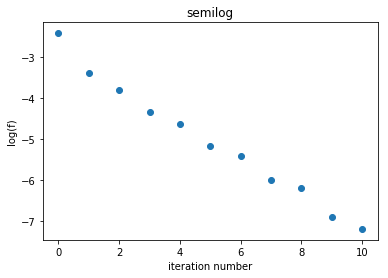

In [24]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [25]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print 'Начальное приближение'
print x0
#x0 = np.array([1., 0.,  0.])

Начальное приближение
[ 0.16034115  0.39808627  0.90322646]


In [26]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

[ 0.47524584  0.74128756 -0.26702268]


In [39]:
print 'x* = ', ans
print 'F(x*) = ', F(ans)
print 'norm check:', np.linalg.norm(ans)

x* =  [ 1.02960592  0.61004039 -0.21726383]
F(x*) =  -0.982112057923
norm check: 1.21632281525


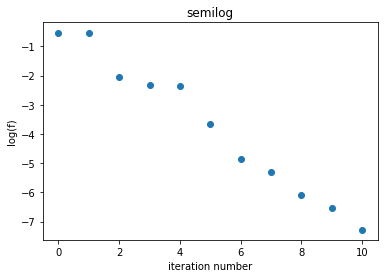

In [28]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [29]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print 'Начальное приближение'
print x0
#x0 = np.array([1., 0.,  0.])

Начальное приближение
[-0.07342681  0.56899925 -0.81905333]


In [30]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

[ 0.64533202  0.43764452 -0.22072192]


In [41]:
print 'x* = ', ans
print 'F(x*) = ', F(ans)
print 'norm check:', np.linalg.norm(ans)

x* =  [ 1.02960592  0.61004039 -0.21726383]
F(x*) =  -0.982112057923
norm check: 1.21632281525


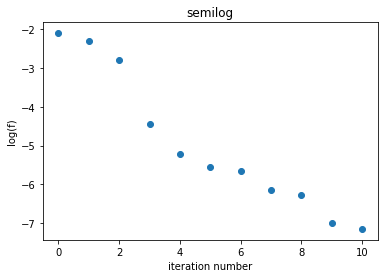

In [42]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [44]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print 'Начальное приближение'
print x0
#x0 = np.array([1., 0.,  0.])

Начальное приближение
[-0.07441054  0.97120326  0.22633449]


In [45]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

[ 0.21280688  0.92300547 -0.22266791]


In [46]:
print 'x* = ', ans
print 'F(x*) = ', F(ans)
print 'norm check:', np.linalg.norm(ans)

x* =  [ 0.21280688  0.92300547 -0.22266791]
F(x*) =  -0.214903690508
norm check: 0.97304001507


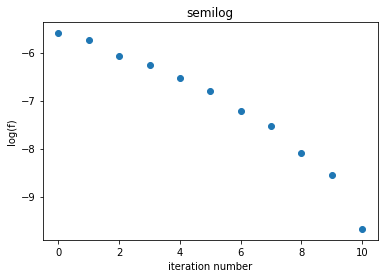

In [47]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [48]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print x0
#x0 = np.array([1., 0.,  0.])

[-0.75203531  0.03808003 -0.65802188]


In [49]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

[ 0.68883453  0.1141244  -0.14343944]


In [50]:
print ans
print F(ans)
print np.linalg.norm(ans)

[ 0.68883453  0.1141244  -0.14343944]
-0.571793440233
0.712805907643


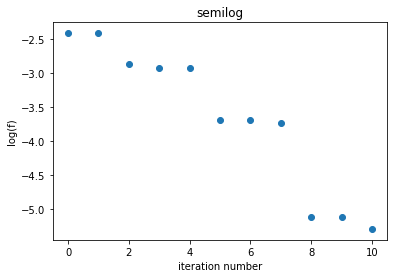

In [51]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [52]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print x0
#x0 = np.array([1., 0.,  0.])

[-0.4488748   0.05326119 -0.89200598]


In [53]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

[ 0.75913393  0.63426505 -0.25704037]


In [54]:
print ans
print F(ans)
print np.linalg.norm(ans)

[ 0.75913393  0.63426505 -0.25704037]
-0.834037767182
1.02207936298


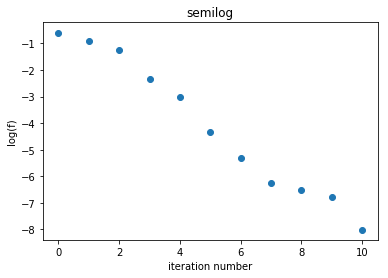

In [55]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()